<a href="https://colab.research.google.com/github/Zaster-TK/INT2_NN/blob/main/Group7F102Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Very Helpful link
# https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html


In [31]:
# Makes File Handling Easier
from collections import OrderedDict
import math
import os
import shutil
import time

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

# from torch.utils.data import DataLoader

# Image datasets and image manipulation
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd

# Image display
import matplotlib.pyplot as plt
import numpy as np

# Unpacker for .mat files
import scipy.io as scio


In [49]:
# Hyper Parameters
BATCH_SIZE = 16
NUM_OF_CLASSES = 102

# Optimizing
LEARN_RATE = 0.001
WEIGHT_DECAY = 0.0001

# Training
MAX_TRAIN_TIME = 60 * 60 * 6
NUM_EPOCHS = 100
CHANCES_TO_IMPROVE = 5

CHECKPOINT_PERIOD = 100

# Transforms
RESIZE_SIZE = 128
CROP_SIZE = 500


In [33]:
# Create train, valid and test directories to sort dataset into.
def makePartitionDirs():
    for i in range(1, 103):
        os.makedirs("data/102flowers/train/" + str(i), exist_ok=True)
        os.makedirs("data/102flowers/test/" + str(i), exist_ok=True)
        os.makedirs("data/102flowers/valid/" + str(i), exist_ok=True)

In [34]:
# # Now obsolete manual partioner for Flowers102 dataset.
# Distribute dataset into train, valid and test directories according to setid.mat specifications.
def partitionData(imageLabels, setid, sortedPath, dataPath):
    for i in range(len(imageLabels["labels"][0])):
        filename = "image_" + str(i + 1).zfill(5) + ".jpg"
        if i + 1 in setid["trnid"][0]:
            targetFolder = os.path.join(
                sortedPath, "train", str(imageLabels["labels"][0][i])
            )
        elif i + 1 in setid["valid"][0]:
            targetFolder = os.path.join(
                sortedPath, "valid", str(imageLabels["labels"][0][i])
            )
        else:
            targetFolder = os.path.join(
                sortedPath, "test", str(imageLabels["labels"][0][i])
            )
        shutil.copy(
            os.path.join(dataPath, filename), os.path.join(targetFolder, filename)
        )

In [50]:
# Commonly-used normalisation values across numerous NNs like Resnet18 and ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
trainTransforms = transforms.Compose(
    [
        transforms.CenterCrop((CROP_SIZE, CROP_SIZE)),
        transforms.Resize((RESIZE_SIZE, RESIZE_SIZE)),
        # transforms.RandomRotation([-90, 180]),
        transforms.RandomRotation(degrees=90),
        transforms.RandomAutocontrast(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)
testTransforms = validTransforms = transforms.Compose(
    [
        transforms.Resize((RESIZE_SIZE, RESIZE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

In [90]:

dataPath = "data/flowers-102"
setid = scio.loadmat(dataPath + f"/setid.mat")
imageLabels: dict = scio.loadmat(dataPath + f"/imagelabels.mat")
trainingData = torchvision.datasets.Flowers102("data", "train", trainTransforms, download=True)
validationData = torchvision.datasets.Flowers102("data", "val", validTransforms, download=True)
testingData = torchvision.datasets.Flowers102("data", "test", testTransforms, download=True)

AttributeError: ignored

In [52]:
# Data loaders for use as input.
trainDataLoader = torch.utils.data.DataLoader(
    trainingData, batch_size=BATCH_SIZE, shuffle=True
)
validDataLoader = torch.utils.data.DataLoader(
    validationData, batch_size=BATCH_SIZE, shuffle=False
)
testDataLoader = torch.utils.data.DataLoader(
    testingData, batch_size=BATCH_SIZE, shuffle=False
)

In [88]:
def showImage(image):
    npImage = image.numpy() / 3.5 + 0.4 # Mostly undoes normalisation for display purposes 
    plt.imshow(np.transpose(npImage, (1, 2, 0)))
    plt.show()

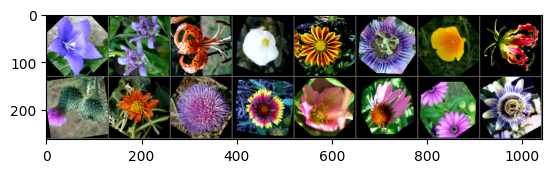

18 78 5 63 70 76 64 20 13 58 28 99 39 16 65 76


In [89]:
def printSampleImages(dataLoader, classIndexes):
    dataIter = iter(trainDataLoader)
    images, labels = next(dataIter)
    showImage(torchvision.utils.make_grid(images))
    print(" ".join(f"{labels[j]}" for j in range(BATCH_SIZE)))
printSampleImages(trainDataLoader, trainingData)

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.tensorMulti = 128 * 32**2

        self.features = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            # nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            # nn.ReLU(),
            # nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            # nn.ReLU(),
            # # nn.Dropout2d(p=0.5),
            # nn.MaxPool2d(2,2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.tensorMulti,1024),
            # nn.ReLU(),
            # nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(1024,102)
        )

    def forward(self, input_img):
        output = self.features(input_img)
        # print(output.shape)
        # output = output.view(-1, self.tensorMulti)
        # print(output.shape)
        output = self.classifier(output)
        return output

# Instantiate a neural network model
model = ConvNet()

In [13]:
# Define the loss function with Classification Cross-Entropy loss and an optimizer with SGD optimizer
lossFunction  = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARN_RATE, weight_decay=WEIGHT_DECAY)

In [14]:
# Function to save the model
def saveModel(path = "./firstF102Model.pth"):
    torch.save(model.state_dict(), path)


In [15]:
# Function to test the model with the validation dataset and print the accuracy for the validation images
def trainingAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in trainDataLoader:
            images, labels = data
            # run the model on the train set to predict labels
            outputs = model(images)
            # the label with the highest value will be predicted
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy

def validateAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in validDataLoader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest value will be predicted
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


In [16]:
def plotAccuracies(trainAccuracies, validAccuracies):
    epochs = len(trainAccuracies)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(range(epochs), trainAccuracies, label='Training accuracy')
    ax1.plot(range(epochs), validAccuracies, label='Validation accuracy')
    ax1.set_title('Training and Validation Accuracies against Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

In [27]:
# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(save_model_path, bestAccuracy = 0.0):
    startTime = time.time()
    lastCheckpointTime = startTime
    trainAccuracies = []
    validAccuracies = []
    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device) # Regretfully AMD GPUs are unsupported for PyTorch models.

    runningAccuracy = 0.0
    fails_to_imprv = 0

    for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
        # Evaluation and Training of the Dataset
        model.train()
        runningLoss = 0.0

        print("\n##############################")
        for i, (images, labels) in enumerate(trainDataLoader):
            # Get the inputs
            images = torch.autograd.Variable(images.to(device))
            labels = torch.autograd.Variable(labels.to(device))
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Predict classes using images from the training set
            outputs = model(images)
            # Compute the loss based on model output and real labels
            loss = lossFunction(outputs, labels)
            # Back-propagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()
            runningLoss += loss.item()  # extract the loss value
            if i % BATCH_SIZE == BATCH_SIZE - 1:
                # print twice per epoch
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, runningLoss / BATCH_SIZE))
                # zero the loss
                runningLoss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all validation images
        trainAccuracy = trainingAccuracy()
        trainAccuracies.append(trainAccuracy)
        validAccuracy = validateAccuracy()
        validAccuracies.append(validAccuracy)
        plotAccuracies(trainAccuracies, validAccuracies)
        print(
            "For epoch",
            epoch + 1,
            "the training accuracy over the whole training set is %.2f %%" % (trainAccuracy),
            "\nthe validation accuracy over the whole validation set is %.2f %%" % (validAccuracy),
        )
        elapsedTime = time.time() - lastCheckpointTime
        if elapsedTime >= CHECKPOINT_PERIOD and validAccuracy > bestAccuracy:
            saveModel(save_model_path)
            lastCheckpointTime = time.time()

        # Check if the maximum training time has elapsed
        elapsedTime  = time.time() - startTime
        if elapsedTime  >= MAX_TRAIN_TIME:
            if validAccuracy > bestAccuracy:
                saveModel(save_model_path)
            break

        if validAccuracy > runningAccuracy:
            print("Improvement made: %.2f%% better." % (validAccuracy - runningAccuracy))
            runningAccuracy = validAccuracy
            fails_to_imprv = 0
        else:
            fails_to_imprv += 1
            print("Failed to improve: %d, %.2f%% worse." % (fails_to_imprv, (runningAccuracy - validAccuracy)))
            if fails_to_imprv >= CHANCES_TO_IMPROVE:
              print("Failed to improve %d consecutive times." % fails_to_imprv)
              break

        # Check if the maximum training time has elapsed
        elapsedTime  = time.time() - startTime
        if (elapsedTime  >= MAX_TRAIN_TIME and validAccuracy > bestAccuracy) or (fails_to_imprv > CHANCES_TO_IMPROVE):
            saveModel(save_model_path)
            break

        # we want to save the model if the accuracy is the best
        if validAccuracy > bestAccuracy:
            saveModel(save_model_path)
            bestAccuracy = validAccuracy
 

In [18]:
# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader
    dataIter = iter(testDataLoader)
    images, labels = next(dataIter)
    showImage(torchvision.utils.make_grid(images))
    print(
        "Real classes: ",
        " ".join(f"{testClassIndexes[int(labels[j])]}" for j in range(BATCH_SIZE)),
    )
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)

    # get probabilities for all 102 labels. The highest (max) probability should align with correct label
    _, predicted = torch.max(outputs, 1)

    # show the predicted labels on the screen with the real ones for comparison
    print(
        "Predicted: ",
        " ".join(f"{testClassIndexes[int(predicted[j])]}" for j in range(BATCH_SIZE)),
    )

In [19]:
# Function to validate the model with a batch of images from the validation set.
def validBatch():
    model.eval()
    dataIter = iter(validDataLoader)
    images, labels = next(dataIter)
    showImage(torchvision.utils.make_grid(images))
    print(
        "Real classes: ",
        " ".join(f"{validClassIndexes[int(labels[j])]}" for j in range(BATCH_SIZE)),
    )
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    print(
        "Predicted: ",
        " ".join(f"{validClassIndexes[int(predicted[j])]}" for j in range(BATCH_SIZE)),
    )


In [20]:
def trainOurModel(save_model_path = "firstF102Model.pth"):
    # best_accurracy = 0.0
    # if os.path.isfile(model_path):
    #     best_model = ConvNet()
    #     # best_optimizer = torch.optim.SGD(best_model.parameters(), lr=LEARN_RATE, weight_decay=WEIGHT_DECAY)
    #     best_model.load_state_dict(torch.load(model_path))
    #     best_accurracy = validateAccuracy(best_model)

    # Let's build our model
    train(save_model_path, 0.0)
    print("Finished Training")

    # Test which classes performed well
    validateAccuracy()

    # Let's load the model we just created and test the accuracy per label
    # Optimizer
    model.load_state_dict(torch.load(save_model_path))

    # Test with batch of images
    validBatch()

In [21]:
# Function to test what classes performed well
def testClasses(model):
    model.eval()
    class_correct = list(0.0 for i in range(NUM_OF_CLASSES))
    class_total = list(0.0 for i in range(NUM_OF_CLASSES))
    with torch.no_grad():
        for data in testDataLoader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(BATCH_SIZE):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(NUM_OF_CLASSES):
        print(
            "Accuracy of %5s : %2d %%"
            % (i, 100 * class_correct[i] / class_total[i])
        )


In [28]:
# Begin the training
trainOurModel("firstF102Model.pth")
# testClasses()


The model will be running on cuda:0 device

##############################


TypeError: ignored